In [101]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "./input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
%matplotlib inline 
import matplotlib.pyplot as plt
import os
# print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

In [102]:

from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np

In [103]:
#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

In [104]:
print(num_symbols)

36


In [105]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    flat = layers.Flatten()(mp3)

    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

In [106]:
def preprocess_data():
    n_samples = len(os.listdir('./input')) #/captcha
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('./input')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('./input', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y


In [107]:
import random
rand_sample_train = random.sample(range(1070), 970)
rand_sample_test = []
for samp in range(1070):
    if (samp not in rand_sample_train):
        rand_sample_test.append(samp)


X, y = preprocess_data()
# X_train, y_train = X[:970], y[:, :970]
# X_test, y_test = X[970:], y[:, 970:]
X_train, y_train = X[rand_sample_train], y[:, rand_sample_train]
X_test, y_test = X[rand_sample_test], y[:, rand_sample_test]

In [108]:
model=create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 50, 200, 16)  160         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 25, 100, 16)  0          ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 25, 100, 32)  4640        ['max_pooling2d_6[0][0]']  

In [109]:
label = [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]]

hist = model.fit(X_train, label, batch_size=32, epochs=30, verbose='auto', validation_split=0.2)

Epoch 1/30
25/25 [==============================] - 7s 145ms/step - loss: 17.9827 - dense_21_loss: 3.6351 - dense_23_loss: 3.5458 - dense_25_loss: 3.5907 - dense_27_loss: 3.6148 - dense_29_loss: 3.5964 - dense_21_accuracy: 0.0425 - dense_23_accuracy: 0.0515 - dense_25_accuracy: 0.0412 - dense_27_accuracy: 0.0464 - dense_29_accuracy: 0.0503 - val_loss: 17.7619 - val_dense_21_loss: 3.5508 - val_dense_23_loss: 3.5465 - val_dense_25_loss: 3.5514 - val_dense_27_loss: 3.5524 - val_dense_29_loss: 3.5608 - val_dense_21_accuracy: 0.0309 - val_dense_23_accuracy: 0.0515 - val_dense_25_accuracy: 0.0619 - val_dense_27_accuracy: 0.0567 - val_dense_29_accuracy: 0.0619
Epoch 2/30
25/25 [==============================] - 3s 121ms/step - loss: 16.8067 - dense_21_loss: 3.3716 - dense_23_loss: 3.2868 - dense_25_loss: 3.4357 - dense_27_loss: 3.3096 - dense_29_loss: 3.4031 - dense_21_accuracy: 0.0696 - dense_23_accuracy: 0.0722 - dense_25_accuracy: 0.0541 - dense_27_accuracy: 0.0722 - dense_29_accuracy: 0.0

In [110]:
y_predict = model.predict(X_test)

4/4 [==============================] - 0s 19ms/step


In [122]:
accu = np.zeros((y_test.shape[0], y_test.shape[1]))
seq_y_test = np.zeros((y_test.shape[0], y_test.shape[1]))
seq_y_predict = np.zeros((y_test.shape[0], y_test.shape[1]))

dict_sym = {}
for sym in symbols:
    dict_sym[sym] = 0

for i in range(y_test.shape[0]):
    for j in range(y_test.shape[1]):
        seq_y_test[i][j] = np.argmax(y_test[i][j])
        seq_y_predict[i][j] = np.argmax(y_predict[i][j])
        if (np.argmax(y_test[i][j]) == np.argmax(y_predict[i][j])):
            accu[i][j] += 1
        else:
            dict_sym[symbols[np.argmax(y_test[i][j])]] += 1
            

In [112]:
print("We could recognize  "+ str(np.sum(accu)) + ' of ' + str(y_test.shape[1] * 5) + ' symbols in Test dataset')

We could recognize  439.0 of 500 symbols in Test dataset


{'a': 0, 'b': 5, 'c': 3, 'd': 2, 'e': 4, 'f': 4, 'g': 3, 'h': 0, 'i': 0, 'j': 0, 'k': 0, 'l': 0, 'm': 8, 'n': 5, 'o': 0, 'p': 2, 'q': 0, 'r': 0, 's': 0, 't': 0, 'u': 0, 'v': 0, 'w': 3, 'x': 4, 'y': 1, 'z': 0, '0': 0, '1': 0, '2': 1, '3': 3, '4': 5, '5': 1, '6': 2, '7': 3, '8': 2, '9': 0}


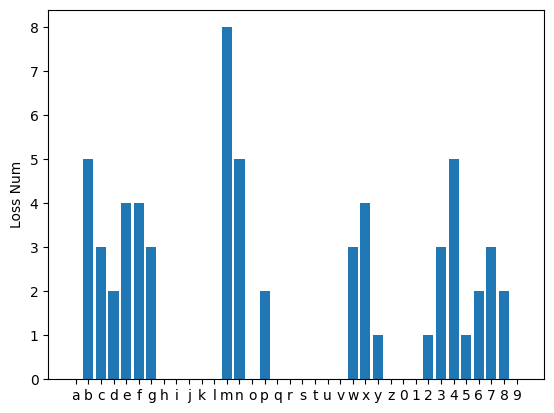

In [121]:
import matplotlib.pyplot as plt

print(dict_sym)

plt.bar(dict_sym.keys(), dict_sym.values())
plt.ylabel('Loss Num')
plt.show()

In [146]:
ds_lb = []
for ind in np.unique(seq_y_predict):
    ds_lb.append(symbols[int(ind)])

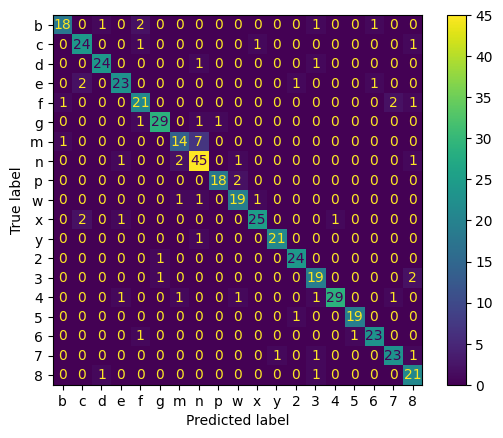

In [147]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(seq_y_test.flatten(), seq_y_predict.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ds_lb)
disp.plot()
plt.show()

{0: 0, 1: 3, 2: 7, 3: 5, 4: 18, 5: 67}


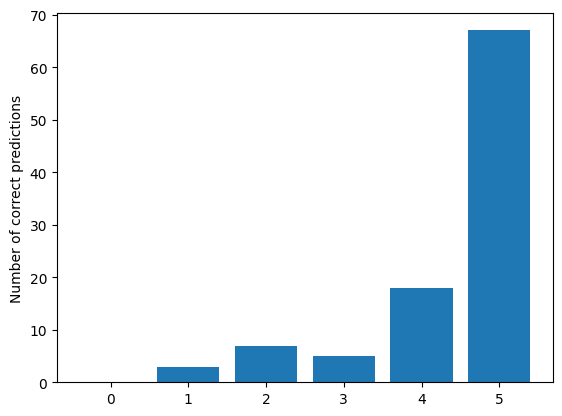

In [119]:
acc_for_each = {}
for i in range(6):
    acc_for_each[i] = np.sum(accu, axis=0)[np.sum(accu, axis=0) == i].shape[0]

print(acc_for_each)

plt.bar(acc_for_each.keys(), acc_for_each.values())
plt.ylabel('Number of correct predictions')
plt.show()

[95. 92. 88. 79. 85.]


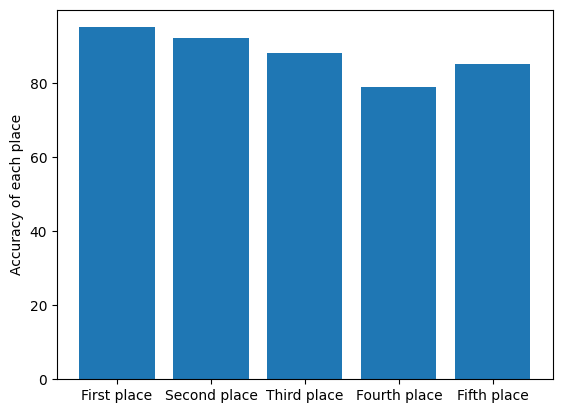

In [120]:
print(np.sum(accu, axis=1))

plt.bar(['First place', 'Second place', 'Third place', 'Fourth place', 'Fifth place'], np.sum(accu, axis=1))
plt.ylabel('Accuracy of each place')
plt.show()

In [116]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    print(img[np.newaxis, :, :, np.newaxis].shape)
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5



In [117]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)

4/4 [==============================] - 0s 21ms/step - loss: 2.4564 - dense_21_loss: 0.0830 - dense_23_loss: 0.3265 - dense_25_loss: 0.4479 - dense_27_loss: 1.0226 - dense_29_loss: 0.5765 - dense_21_accuracy: 0.9500 - dense_23_accuracy: 0.9200 - dense_25_accuracy: 0.8800 - dense_27_accuracy: 0.7900 - dense_29_accuracy: 0.8500
Test Loss and accuracy: [2.45642352104187, 0.08296152204275131, 0.3265392780303955, 0.4479009509086609, 1.0225566625595093, 0.5764652490615845, 0.949999988079071, 0.9200000166893005, 0.8799999952316284, 0.7900000214576721, 0.8500000238418579]


In [148]:
# Check model on some samples
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print(predict('./input/8n5p3.png'))
print(predict('./input/f858x.png'))
print(predict('./input/wm47f.png'))
print(predict('./input/x362g.png'))
print(predict('./input/ygenn.png'))

4/4 [==============================] - 0s 25ms/step - loss: 2.4564 - dense_21_loss: 0.0830 - dense_23_loss: 0.3265 - dense_25_loss: 0.4479 - dense_27_loss: 1.0226 - dense_29_loss: 0.5765 - dense_21_accuracy: 0.9500 - dense_23_accuracy: 0.9200 - dense_25_accuracy: 0.8800 - dense_27_accuracy: 0.7900 - dense_29_accuracy: 0.8500
(1, 50, 200, 1)
1/1 [==============================] - 0s 23ms/step
8n5p3
(1, 50, 200, 1)
1/1 [==============================] - 0s 29ms/step
f858x
(1, 50, 200, 1)
1/1 [==============================] - 0s 32ms/step
wmm87
(1, 50, 200, 1)
1/1 [==============================] - 0s 28ms/step
x362g
(1, 50, 200, 1)
1/1 [==============================] - 0s 39ms/step
ygenn
